In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

defining wWsserstein loss

In [2]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

Building WGAN Model

In [3]:
def build_generator(latent_dim, img_shape, complexity):
    model = models.Sequential()
    model.add(layers.Dense(complexity, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(2*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(3*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(layers.Reshape(img_shape))
    return model

def build_critic(img_shape,complexity):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(3*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(2*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1))
    return model

def build_wgan(generator, critic):
    critic.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(critic)
    return model


Computing EMD

In [4]:
def earth_mover_distance(X, Y):
    return np.mean(np.sqrt(np.sum((X - Y) ** 2, axis=(1, 2, 3))))

def compute_emd(generator, latent_dim):
    noise = np.random.normal(0, 1, (100, latent_dim))
    generated_images = generator.predict(noise)

    (_, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
    X_test = (X_test.astype(np.float32) - 127.5) / 127.5
    #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    #X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    emd = 0
    for i in range(10):
        emd += earth_mover_distance(X_test[i * 100:(i + 1) * 100], generated_images)
    emd /= 10
    return emd

Function to plot original and constructed images

In [5]:

def plot_original_and_generated_images(generator, epoch, latent_dim, examples=10, dim=(2, 10), figsize=(15, 3)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2  # Rescale images 0 to 1
    generated_images = generated_images.reshape(examples, 28, 28)  # Adjust for MNIST grayscale images

    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    original_images = X_train[np.random.randint(0, X_train.shape[0], size=examples)] / 255.0  # Normalize to [0, 1]

    plt.figure(figsize=(15, 5))
    for i in range(examples):
        # Plot original image with title
        plt.subplot(dim[0], dim[1], i * 2 + 1)
        plt.imshow(original_images[i])
        plt.title("Original Image", fontsize=8)
        plt.axis('off')


        # Plot generated image with title
        plt.subplot(dim[0], dim[1], i * 2 + 2)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.title("Generated Image", fontsize=8)
        plt.axis('off')

Plotting EMD

In [6]:
def plot_emd_history(emd_values):
    plt.figure(figsize=(10, 5))
    plt.plot(emd_values)
    plt.title('EMD over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('EMD')
    plt.show()

Training WGAN Model

In [7]:
def train_wgan(generator, critic, wgan, epochs, batch_size, latent_dim):
    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    X_train = np.expand_dims(X_train, axis=-1)

    critic.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(lr=0.00005))
    wgan.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(lr=0.00005))

    emd_values = []

    for epoch in range(epochs):
        for _ in range(X_train.shape[0] // batch_size):
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_images = generator.predict(noise)

            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_images = X_train[idx]

            valid = -np.ones((batch_size, 1))
            fake = np.ones((batch_size, 1))

            d_loss_real = critic.train_on_batch(real_images, valid)
            d_loss_fake = critic.train_on_batch(generated_images, fake)
            d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            valid = -np.ones((batch_size, 1))
            g_loss = wgan.train_on_batch(noise, valid)

        emd = compute_emd(generator, latent_dim)
        emd_values.append(emd)

        print(f"Epoch {epoch}, EMD: {emd}")
        #plot_original_and_generated_images(generator, epoch, latent_dim)

    return generator, emd_values

Setting up general parameter

In [8]:
epochs = 5
batch_size = 128

Behaviour of latent dimensionality values

With latent_dim=5 and complexity=128


4/4 [==============================] - 0s 5ms/step
Epoch 0, EMD: 38.93539733886719
4/4 [==============================] - 0s 5ms/step
Epoch 1, EMD: 38.926238250732425
4/4 [==============================] - 0s 4ms/step
Epoch 2, EMD: 38.956129455566405
4/4 [==============================] - 0s 5ms/step
Epoch 3, EMD: 38.94160957336426
4/4 [==============================] - 0s 5ms/step
Epoch 4, EMD: 38.95931549072266


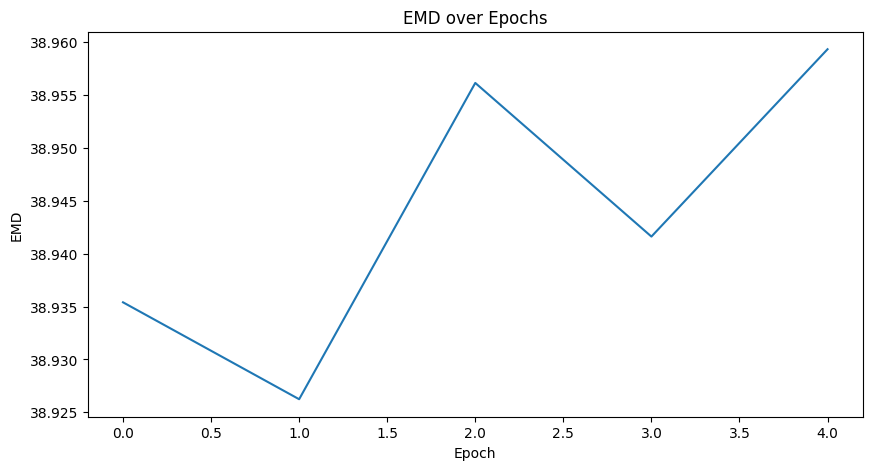

1/1 [==============================] - 0s 35ms/step
With latent_dim=10 and complexity=128


4/4 [==============================] - 0s 6ms/step
Epoch 0, EMD: 38.12985534667969
4/4 [==============================] - 0s 5ms/step
Epoch 1, EMD: 38.032278060913086
4/4 [==============================] - 0s 4ms/step
Epoch 2, EMD: 38.11185569763184
4/4 [==============================] - 0s 5ms/step
Epoch 3, EMD: 38.115835952758786
4/4 [==============================] - 0s 4ms/step
Epoch 4, EMD: 38.07900733947754


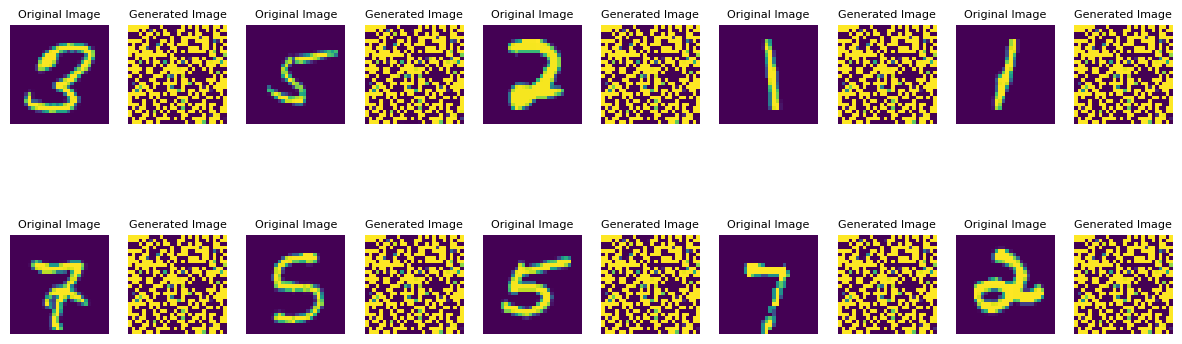

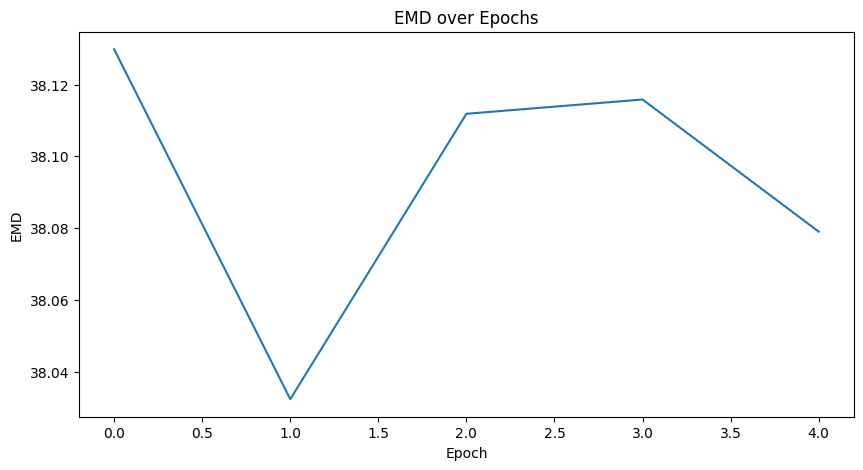

1/1 [==============================] - 0s 24ms/step
With latent_dim=50 and complexity=128


4/4 [==============================] - 0s 4ms/step
Epoch 0, EMD: 37.474130630493164
4/4 [==============================] - 0s 4ms/step
Epoch 1, EMD: 37.49360656738281
4/4 [==============================] - 0s 5ms/step
Epoch 2, EMD: 37.482255935668945
4/4 [==============================] - 0s 4ms/step
Epoch 3, EMD: 37.49024963378906
4/4 [==============================] - 0s 5ms/step
Epoch 4, EMD: 37.486737442016604


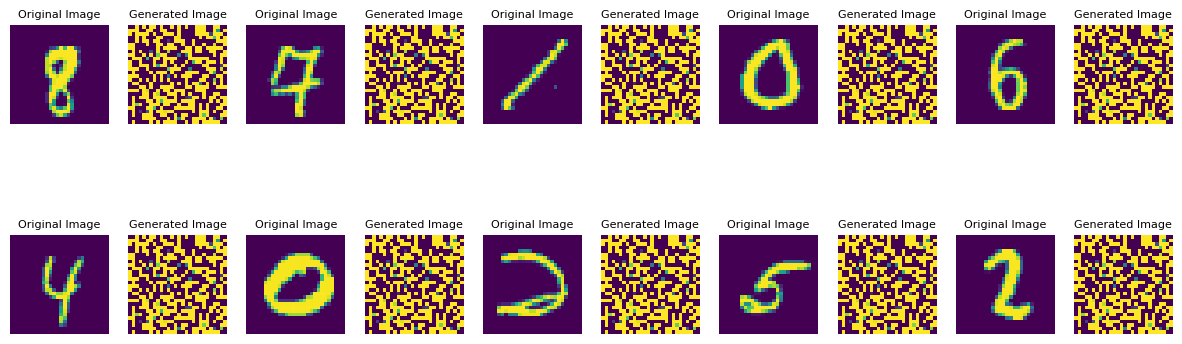

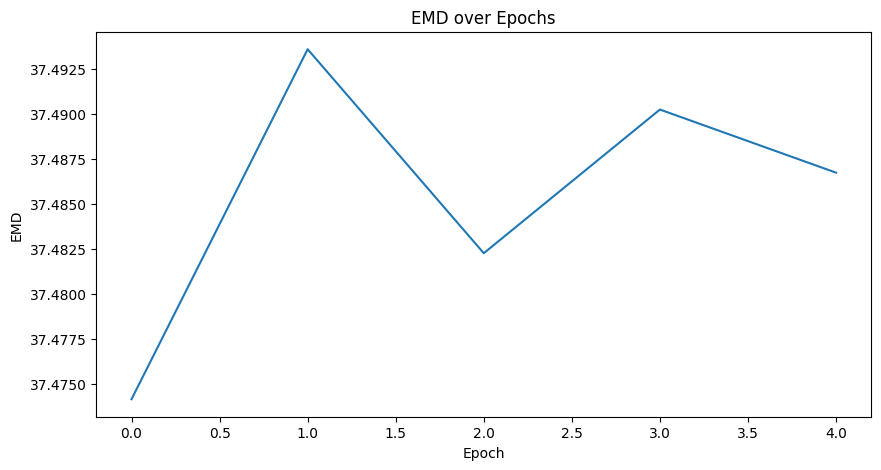

1/1 [==============================] - 0s 23ms/step
With latent_dim=100 and complexity=128


4/4 [==============================] - 0s 4ms/step
Epoch 0, EMD: 39.015295791625974
4/4 [==============================] - 0s 4ms/step
Epoch 1, EMD: 39.078291702270505
4/4 [==============================] - 0s 4ms/step
Epoch 2, EMD: 39.06888084411621
4/4 [==============================] - 0s 4ms/step
Epoch 3, EMD: 39.07744445800781
4/4 [==============================] - 0s 4ms/step
Epoch 4, EMD: 39.06791038513184


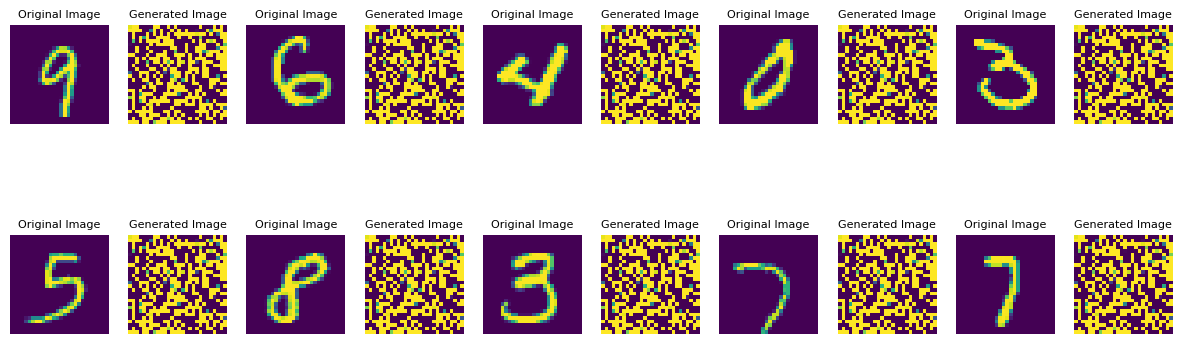

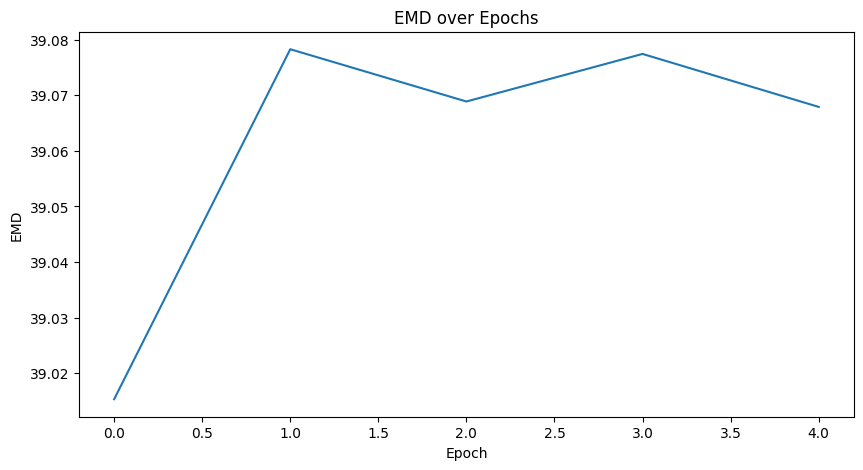

1/1 [==============================] - 0s 24ms/step


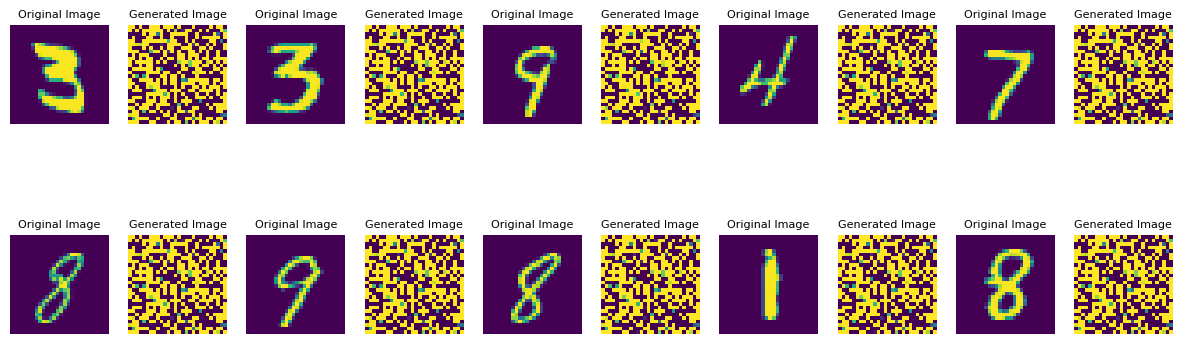

In [9]:
latent_dim_values = [5, 10, 50, 100]
complexity = 128

img_shape = (28, 28, 1)

for latent_dim in latent_dim_values:
      print(f"With latent_dim={latent_dim} and complexity={complexity}")

      generator = build_generator(latent_dim, img_shape, complexity)
      critic = build_critic(img_shape, complexity)
      wgan = build_wgan(generator, critic)
      generator, emd_values = train_wgan(generator, critic, wgan, epochs, batch_size, latent_dim)
      plot_emd_history(emd_values)
      plot_original_and_generated_images(generator, epochs, latent_dim)

Behaviour of complexity values

With latent_dim=100 and complexity=32


4/4 [==============================] - 0s 4ms/step
Epoch 0, EMD: 38.69787940979004
4/4 [==============================] - 0s 4ms/step
Epoch 1, EMD: 38.76392364501953
4/4 [==============================] - 0s 4ms/step
Epoch 2, EMD: 38.742346572875974
4/4 [==============================] - 0s 3ms/step
Epoch 3, EMD: 38.77958679199219
4/4 [==============================] - 0s 4ms/step
Epoch 4, EMD: 38.816430282592776


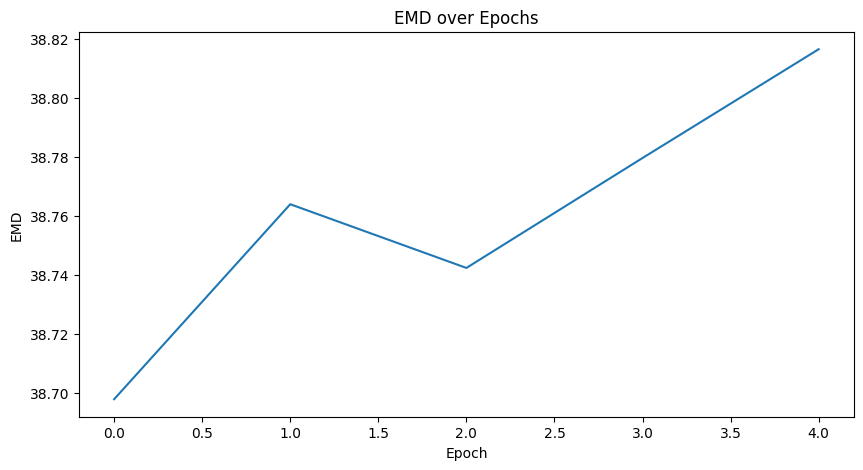

1/1 [==============================] - 0s 26ms/step
With latent_dim=100 and complexity=64


4/4 [==============================] - 0s 4ms/step
Epoch 0, EMD: 37.786460876464844
4/4 [==============================] - 0s 3ms/step
Epoch 1, EMD: 37.68866386413574
4/4 [==============================] - 0s 3ms/step
Epoch 2, EMD: 37.68950653076172
4/4 [==============================] - 0s 4ms/step
Epoch 3, EMD: 37.68093490600586
4/4 [==============================] - 0s 5ms/step
Epoch 4, EMD: 37.672983169555664


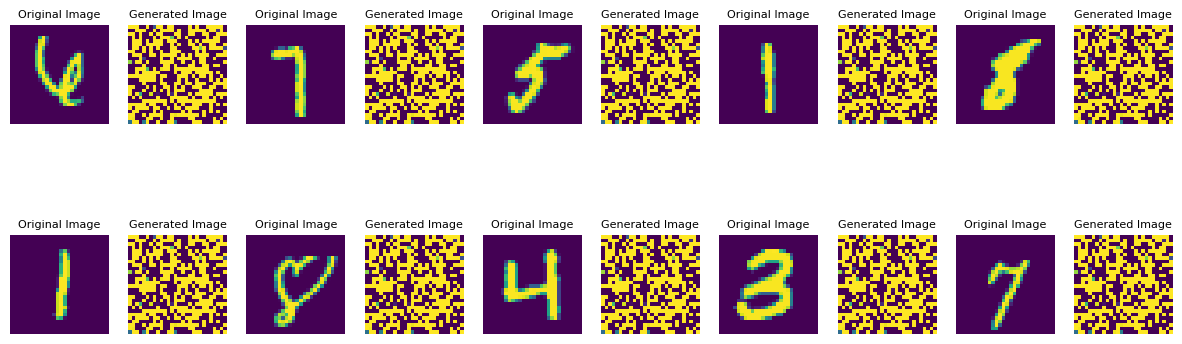

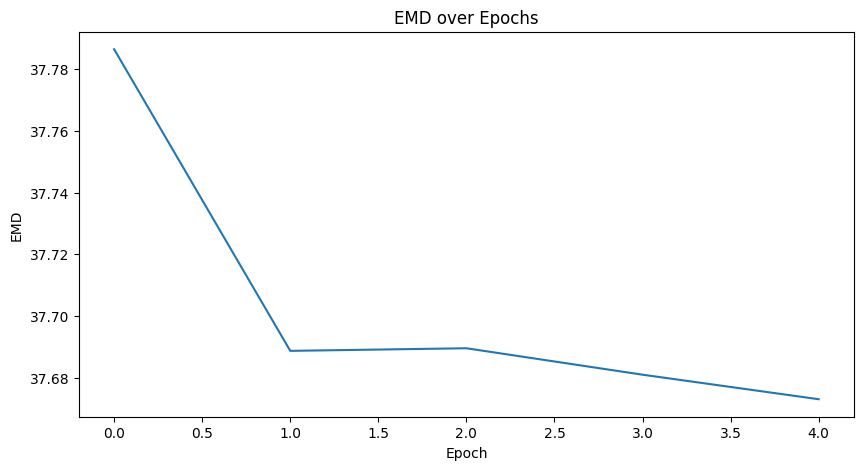

1/1 [==============================] - 0s 23ms/step
With latent_dim=100 and complexity=128


4/4 [==============================] - 0s 4ms/step
Epoch 0, EMD: 37.935112380981444
4/4 [==============================] - 0s 4ms/step
Epoch 1, EMD: 37.93502693176269
4/4 [==============================] - 0s 4ms/step
Epoch 2, EMD: 37.94791488647461
4/4 [==============================] - 0s 5ms/step
Epoch 3, EMD: 37.947045135498044
4/4 [==============================] - 0s 4ms/step
Epoch 4, EMD: 37.919691467285155


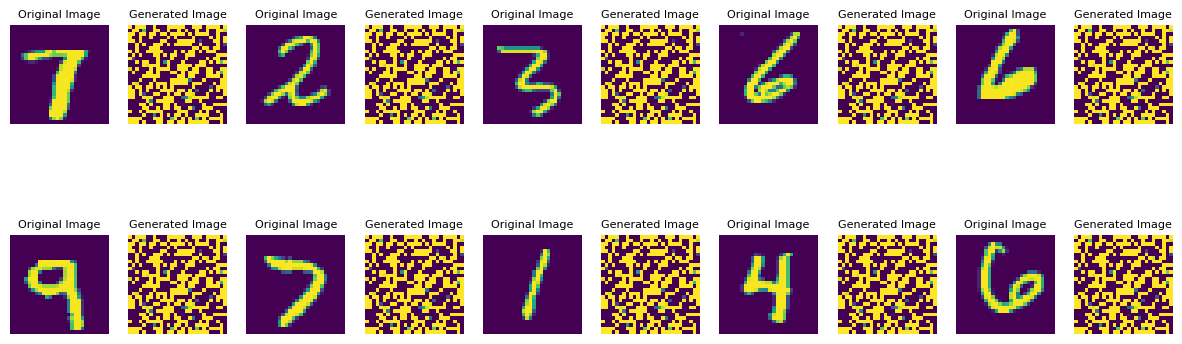

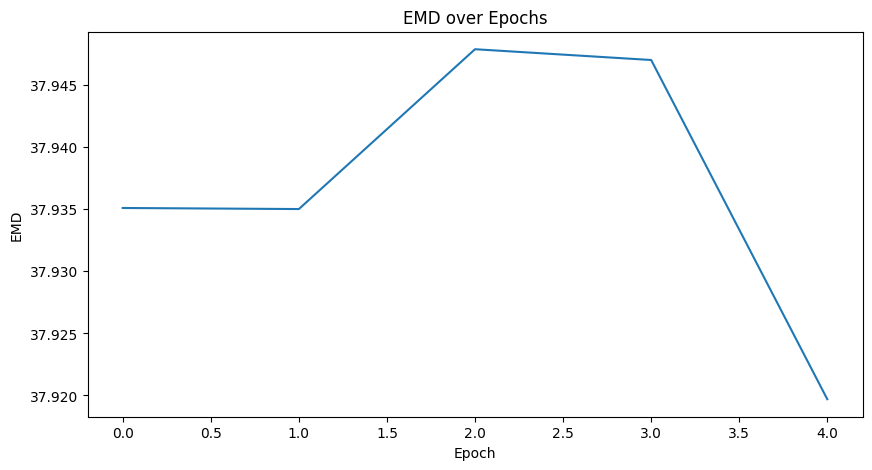

1/1 [==============================] - 0s 25ms/step
With latent_dim=100 and complexity=256


4/4 [==============================] - 0s 5ms/step
Epoch 0, EMD: 38.189012908935545
4/4 [==============================] - 0s 5ms/step
Epoch 1, EMD: 38.14822578430176
4/4 [==============================] - 0s 6ms/step
Epoch 2, EMD: 38.15144386291504
4/4 [==============================] - 0s 6ms/step
Epoch 3, EMD: 38.14564514160156
4/4 [==============================] - 0s 5ms/step
Epoch 4, EMD: 38.136392974853514


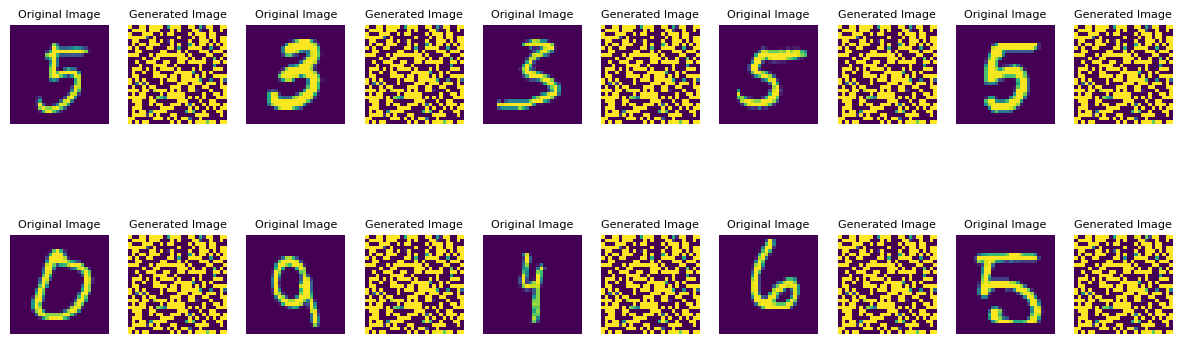

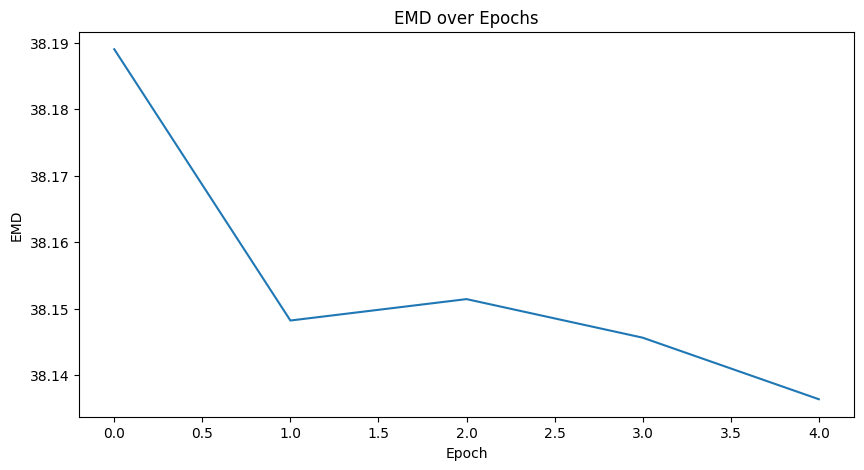

1/1 [==============================] - 0s 25ms/step


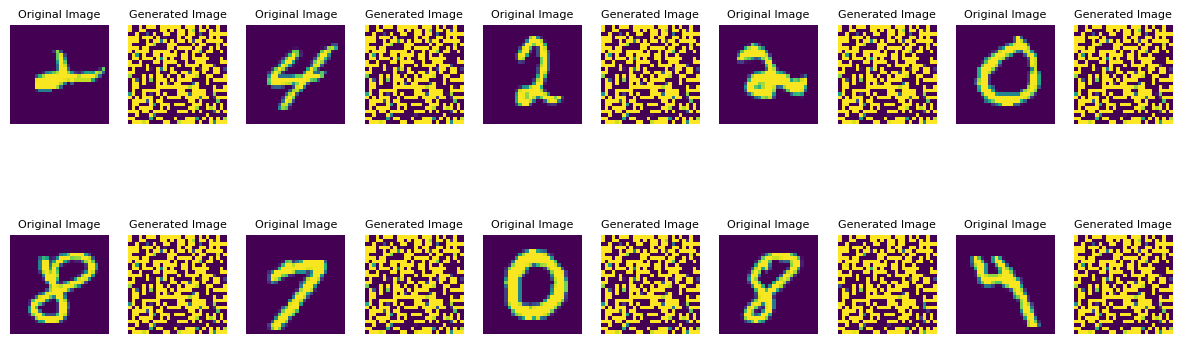

In [10]:
latent_dim = 100
complexity_values = [32, 64, 128, 256]

img_shape = (28, 28, 1)

for complexity in complexity_values:
      print(f"With latent_dim={latent_dim} and complexity={complexity}")

      generator = build_generator(latent_dim, img_shape, complexity)
      critic = build_critic(img_shape, complexity)
      wgan = build_wgan(generator, critic)
      generator, emd_values = train_wgan(generator, critic, wgan, epochs, batch_size, latent_dim)
      plot_emd_history(emd_values)
      plot_original_and_generated_images(generator, epochs, latent_dim)